# Revised Magnitude tests
What exactly does magnitude correlate in word embeddings from Large Language Models? Can we find markers of complexity in differences between clearly defined groups of English language words?

I will compare dialects (British-English, American-English), plurals (wife, wives), and Oxford Corpus frequencies as a part of attempting to investigate these issues.

In [1]:
import os
import torch
import openai
import numpy as np

import sentencepiece    # necessary for proper t5 init.
from transformers import T5Tokenizer, T5EncoderModel, GPT2Tokenizer, OPTModel

from sklearn.metrics.pairwise import cosine_similarity

# api key set in conda env.
openai.api_key = os.getenv('OPENAI_API_KEY')

## Load Models

### Vocab

In [2]:
vocab = []
with open('./vocab/expanded_vocab.txt', 'r') as f:
    for line in f:
        vocab.append(line.strip())

len(vocab)

5124

In [3]:
top_50 = []
with open('./vocab/top_50.txt', 'r') as f:
    for line in f:
        top_50.append(line.strip())

bottom_50 = []
with open('./vocab/bottom_50.txt', 'r') as f:
    for line in f:
        bottom_50.append(line.strip())

### OPT-1.3b

In [4]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('facebook/opt-1.3b', cache_dir='/scratch/mbarlow6/.cache')
model_opt_raw = OPTModel.from_pretrained('facebook/opt-1.3b', cache_dir='/scratch/mbarlow6/.cache')

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTModel: ['model.decoder.final_layer_norm.weight', 'lm_head.weight', 'model.decoder.final_layer_norm.bias']
- This IS expected if you are initializing OPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
opt_embeds = []
with open(u'./opt/1_3B.txt', 'r') as f:
    for line in f:
        opt_embeds.append([float(x) for x in line.strip().split()])
model_opt = dict(zip(vocab, opt_embeds))

In [6]:
def opt_embed(text, tokenizer=gpt2_tokenizer, model=model_opt_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings[1:], dim=0))

### T5

In [7]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-large', cache_dir='/scratch/mbarlow6/.cache')
model_t5_raw = T5EncoderModel.from_pretrained('t5-large', cache_dir='/scratch/mbarlow6/.cache')

/home/mbarlow6/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.20.layer.0.SelfAttention.o.weight', 'decoder.block.6.layer.1.EncDecAttention.q.weight', 'decoder.block.14.layer.2.DenseReluD

In [8]:
t5_embeds = []
with open('./t5/t5large.txt', 'r') as f:
    for line in f:
        t5_embeds.append([float(x) for x in line.strip().split()])
model_t5 = dict(zip(vocab, t5_embeds))

In [9]:
def t5_embed(text, tokenizer=t5_tokenizer, model=model_t5_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings, dim=0))

## Helper Functions

In [10]:
def positive(words, model='opt'):
    """
    Args:
        words: iterable
        model: 'opt' or 't5'
    Returns:
        Positive (summed vectors) of word embeddings of a given list of words from the specified model. Defaults to OPT-1.3b.
    """
    if isinstance(words, str):
        print(f"You requested the positive of the string \"{words}\". Did you mean [\"{words}\"]?")

    out = 0
    for token in words:
        word = str(token)
        if model.lower() == 'opt':
            if word in model_opt:
                ex = model_opt[word]
            else:
                ex = opt_embed(word)
                model_opt[word] = ex
        elif model.lower() == 't5':
            if word in model_t5:
                ex = model_t5[word]
            else:
                ex = t5_embed(word)
                model_t5[word] = ex
        else:
            raise ValueError('Please provide either opt or t5 as a model choice.')

        # construct positive
        if isinstance(out, int):
            out = np.array(ex).reshape(1, -1)
        else:
            out += np.array(ex).reshape(1, -1)
            
    return out if not isinstance(out, int) else np.array([])

In [11]:
def sum_complexity(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the sum of the absolute value of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [abs(float(x)) for x in phrase[0]]
    return sum(modified)
    

In [12]:
def simple_sum(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the simple sum of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [float(x) for x in phrase[0]]
    return sum(modified)

In [13]:
def similar_dims(w1, w2, n=10):
    # performs dimension-wise comparison of two vectors of EQUAL size
    # returns the top and bottom n scores.
    sims = []
    for i in range(w1.shape[1]):
        x = w1[0][i]
        y = w2[0][i]
        sims.append((i, (x, y), abs(x-y)))
    sims.sort(key=lambda x: x[2])
    return sims[:n], sims[len(sims)-n:]

In [129]:
def sig_dim(word, topn=5, model='opt'):
    """
    Args:
        word: str   target word to evaluate
        topn: int   number of dimesions to return
        model: str  'opt' or 't5'. Defaults to 'opt'.
    Returns:
        Indices of the n largest dimensions in the vector embedding of word in model.
    """
    p = positive([word], model=model)
    helper = []
    for i in range(len(p[0])):
        helper.append((i, p[0][i]))
    helper.sort(key=lambda x: abs(x[1]), reverse=True)
    return helper[:topn]

In [37]:
def compare_mag(words):
    """
    Wrapper for direct comparison using our magnitude tests
    """
    if isinstance(words, str):
        words = [words] 
    for word in words:
        print(word)
        print(f"\t\tOPT\t\t\tT5")
        print(f"Simple Sum:\t{simple_sum(word)}\t{simple_sum(word, model='t5')}")
        print(f"Absolute Sum:\t{sum_complexity(word)}\t{sum_complexity(word, model='t5')}")
        print(f"Signif. Dims:\tOPT: {sig_dim(word)}\n\t\tT5:  {sig_dim(word, model='t5')}")
        print('--------------------------------------------------------------\n')
        

## Run Tests

### American -> British English

In [130]:
compare_mag(['color', 'colour'])

color
		OPT			T5
Simple Sum:	-24.199456945061684	-4.4587583602406085
Absolute Sum:	3338.171229749918	112.67953831842169
Signif. Dims:	OPT: [(1346, -15.877882), (734, 13.063267), (1583, 11.354231), (614, -10.009372), (1651, -9.197855)]
		T5:  [(79, 1.3721677), (58, -1.3272331), (1003, 0.9397749), (674, 0.85065126), (300, 0.8262855)]
--------------------------------------------------------------

colour
		OPT			T5
Simple Sum:	-22.662603956949933	-0.01963315483000075
Absolute Sum:	3335.5094612935595	102.75824530782984
Signif. Dims:	OPT: [(1346, -16.255703), (734, 12.329848), (1583, 10.510461), (614, -10.506335), (1651, -9.156858)]
		T5:  [(58, -0.7834113), (79, 0.76460105), (1003, 0.5303976), (300, 0.51883906), (454, -0.4953524)]
--------------------------------------------------------------



In [131]:
compare_mag(['flavor', 'flavour'])

flavor
		OPT			T5
Simple Sum:	-33.566729525104165	-4.6213948333170265
Absolute Sum:	2553.7569937165827	108.81001204042695
Signif. Dims:	OPT: [(1359, -16.475115), (1219, -13.802651), (1583, 10.613891), (1606, 7.971688), (262, -7.9333596)]
		T5:  [(58, -0.62678313), (174, 0.5377159), (90, -0.5364932), (79, 0.51508325), (710, 0.50071156)]
--------------------------------------------------------------

flavour
		OPT			T5
Simple Sum:	-31.49281551646394	0.8406818178199947
Absolute Sum:	2586.2954213954436	93.8045069266
Signif. Dims:	OPT: [(1359, -18.25383), (1219, -14.340467), (1583, 11.40737), (1606, 8.295808), (734, 7.6389885)]
		T5:  [(58, -0.6208956), (674, 0.5958246), (243, -0.5242331), (300, 0.5206183), (765, 0.5133182)]
--------------------------------------------------------------



In [132]:
compare_mag(['apologize', 'apologise'])

apologize
		OPT			T5
Simple Sum:	-40.51664127009994	1.131177949715998
Absolute Sum:	2996.214361116699	120.69495491850398
Signif. Dims:	OPT: [(1359, -20.304375), (734, 17.171865), (262, -14.944145), (396, -13.640128), (1219, -12.52629)]
		T5:  [(801, -0.8549218), (58, -0.79895973), (79, 0.7133422), (77, -0.52684534), (454, -0.46894252)]
--------------------------------------------------------------

apologise
		OPT			T5
Simple Sum:	-36.695555716753006	-2.0030089664433035
Absolute Sum:	2953.673937305808	62.17443947496213
Signif. Dims:	OPT: [(1359, -20.183487), (734, 15.433517), (262, -14.445484), (396, -13.958284), (1219, -12.375431)]
		T5:  [(255, 0.36152917), (738, -0.2588432), (568, 0.2467746), (79, 0.23702931), (1003, 0.2353082)]
--------------------------------------------------------------



In [133]:
compare_mag(['organize', 'organise'])

organize
		OPT			T5
Simple Sum:	-48.99945621659992	4.158821312727008
Absolute Sum:	2884.713562120402	117.27759976698687
Signif. Dims:	OPT: [(1346, -26.24646), (734, 18.07137), (1583, 15.9301815), (396, -11.462064), (614, -11.399872)]
		T5:  [(58, -0.91802585), (79, 0.8581444), (454, -0.62519634), (801, -0.5745743), (72, 0.56945384)]
--------------------------------------------------------------

organise
		OPT			T5
Simple Sum:	-43.70867237821221	2.870686980546452
Absolute Sum:	2863.3498784564435	93.91056684602518
Signif. Dims:	OPT: [(1346, -26.925346), (734, 16.897917), (1583, 15.99848), (396, -13.3179035), (1279, -11.807359)]
		T5:  [(79, 0.8919555), (58, -0.61499053), (1003, 0.60739076), (454, -0.51117325), (174, 0.4570483)]
--------------------------------------------------------------



In [134]:
compare_mag(['analyze', 'analyse'])

analyze
		OPT			T5
Simple Sum:	-37.04013854265213	3.602266021305695
Absolute Sum:	2606.2433263212442	119.0364482162986
Signif. Dims:	OPT: [(1346, -13.204066), (1359, -12.926373), (1952, 12.811195), (1583, 12.620779), (734, 11.994207)]
		T5:  [(79, 0.7456727), (58, -0.67174715), (454, -0.5562001), (554, 0.52620673), (1003, 0.5075937)]
--------------------------------------------------------------

analyse
		OPT			T5
Simple Sum:	-30.81358285315035	7.398864579660009
Absolute Sum:	2651.8206000805553	113.73996778445986
Signif. Dims:	OPT: [(1346, -17.341417), (1952, 14.6062355), (1583, 13.452054), (734, 12.851945), (1359, -12.149761)]
		T5:  [(79, 0.9236711), (58, -0.92190385), (454, -0.6175029), (1003, 0.5229088), (491, 0.49220127)]
--------------------------------------------------------------



In [135]:
compare_mag(['traveled', 'travelled'])

traveled
		OPT			T5
Simple Sum:	-23.362738974392414	-0.5703872325830162
Absolute Sum:	3241.784173555672	119.44546336261556
Signif. Dims:	OPT: [(1346, -25.186893), (1279, -20.87546), (1952, 18.195606), (734, 17.899988), (262, -10.616161)]
		T5:  [(58, -0.74656516), (174, 0.57158065), (1003, 0.5611387), (300, 0.551581), (57, -0.514731)]
--------------------------------------------------------------

travelled
		OPT			T5
Simple Sum:	-46.70141828793567	2.2768816815223545
Absolute Sum:	2560.8489447111497	96.65132482850458
Signif. Dims:	OPT: [(1359, -16.985344), (262, -15.775089), (1219, -13.158261), (734, 11.859042), (1606, 11.040282)]
		T5:  [(79, 1.1161548), (58, -0.7787618), (1003, 0.6665931), (454, -0.5627849), (568, 0.49278462)]
--------------------------------------------------------------



In [136]:
compare_mag(['maneuver', 'manoeuvre'])

maneuver
		OPT			T5
Simple Sum:	-54.64741054340266	6.0926067642867565
Absolute Sum:	2482.6454264416825	117.19327442254871
Signif. Dims:	OPT: [(1346, -20.002565), (734, 13.605464), (1219, -12.201678), (1359, -11.148047), (262, -10.792412)]
		T5:  [(216, -0.59045696), (58, -0.53419393), (219, -0.5311818), (829, 0.5255685), (79, 0.47599363)]
--------------------------------------------------------------

manoeuvre
		OPT			T5
Simple Sum:	-53.18171181541402	2.052766346576391
Absolute Sum:	2764.0729985776125	111.96922191584599
Signif. Dims:	OPT: [(1346, -21.747719), (1583, 17.517403), (734, 17.098274), (262, -15.725219), (1359, -13.92199)]
		T5:  [(79, 1.1236645), (58, -0.928696), (300, 0.83035946), (674, 0.7962964), (1003, 0.7878356)]
--------------------------------------------------------------



In [137]:
compare_mag(['pediatric', 'paediatric'])

pediatric
		OPT			T5
Simple Sum:	-42.69999048486352	-5.073570327484049
Absolute Sum:	2622.081271354109	132.95897158107255
Signif. Dims:	OPT: [(734, 15.797813), (1359, -15.301594), (1219, -13.495563), (1583, 12.182018), (1346, -10.670933)]
		T5:  [(568, 0.7613714), (174, 0.710717), (300, 0.6996859), (1003, 0.6957804), (79, 0.6835506)]
--------------------------------------------------------------

paediatric
		OPT			T5
Simple Sum:	-47.01118626992684	5.113009257009253
Absolute Sum:	2472.705970560317	87.10109771904536
Signif. Dims:	OPT: [(1359, -21.28542), (1219, -16.29404), (262, -13.396477), (1583, 12.85421), (1700, 11.402363)]
		T5:  [(717, -0.35793105), (57, -0.3265383), (866, 0.30769235), (954, -0.28861603), (788, 0.28719258)]
--------------------------------------------------------------



In [138]:
compare_mag(['license', 'licence'])

license
		OPT			T5
Simple Sum:	1.0644383036001321	1.718059176934
Absolute Sum:	2643.3840186575994	111.15593933449402
Signif. Dims:	OPT: [(1583, 10.75869), (263, -10.209788), (1952, 8.500656), (1359, -7.4444776), (734, 7.3019366)]
		T5:  [(58, -0.8112959), (801, -0.74059856), (79, 0.70205784), (300, 0.63292444), (674, 0.6034671)]
--------------------------------------------------------------

licence
		OPT			T5
Simple Sum:	-31.660695239299926	1.4107092056999957
Absolute Sum:	2489.0596044227	74.78809330620007
Signif. Dims:	OPT: [(1583, 13.502406), (1359, -11.65093), (1952, 10.577638), (734, 9.83396), (1219, -9.694756)]
		T5:  [(765, 0.3848821), (390, -0.29573908), (255, 0.28876156), (797, -0.26673928), (484, -0.2604692)]
--------------------------------------------------------------



In [139]:
compare_mag(['offence', 'offense'])

offence
		OPT			T5
Simple Sum:	-44.55477309316994	-2.84851692696
Absolute Sum:	2785.8218766989685	119.99849496604003
Signif. Dims:	OPT: [(1346, -24.422699), (734, 14.414692), (1952, 13.322756), (1279, -13.057405), (1583, 12.226042)]
		T5:  [(79, 0.8543906), (300, 0.7935507), (674, 0.77138406), (58, -0.70973855), (1003, 0.63282794)]
--------------------------------------------------------------

offense
		OPT			T5
Simple Sum:	-46.572157309499985	2.984876640603298
Absolute Sum:	2836.9261814895026	116.24461967640323
Signif. Dims:	OPT: [(1346, -25.55234), (734, 15.142099), (1952, 12.587564), (262, -11.980363), (1279, -11.346793)]
		T5:  [(79, 1.3366308), (58, -1.27018), (568, 0.8474212), (801, -0.82331496), (1003, 0.8185519)]
--------------------------------------------------------------



In [140]:
compare_mag(['analog', 'analogue'])

analog
		OPT			T5
Simple Sum:	-76.26342221349478	5.17538236733526
Absolute Sum:	3077.7593590542674	118.81355411047116
Signif. Dims:	OPT: [(1346, -37.318245), (734, 16.477358), (1219, -12.865699), (614, -12.079979), (262, -11.3961935)]
		T5:  [(79, 1.0235738), (58, -0.77253234), (454, -0.6896259), (77, -0.64644146), (1003, 0.53829753)]
--------------------------------------------------------------

analogue
		OPT			T5
Simple Sum:	-77.15367209166288	7.2690307177836075
Absolute Sum:	3010.94985435158	93.6674624356674
Signif. Dims:	OPT: [(1346, -37.954514), (734, 14.911506), (614, -12.247381), (1279, -11.417662), (1219, -10.972965)]
		T5:  [(58, -0.40450475), (79, 0.3531697), (611, 0.34376293), (255, 0.33538777), (852, -0.33130252)]
--------------------------------------------------------------



### Simple plurals

In [141]:
compare_mag(['wife', 'wives'])

wife
		OPT			T5
Simple Sum:	5.2352011217000145	2.3213250735199944
Absolute Sum:	3150.2644422225003	120.24246082537995
Signif. Dims:	OPT: [(1346, -19.537697), (734, 13.971472), (262, -10.213686), (1279, -9.88703), (1583, 8.962568)]
		T5:  [(79, 0.9077228), (58, -0.6672324), (801, -0.6359598), (1003, 0.6227946), (174, 0.62223685)]
--------------------------------------------------------------

wives
		OPT			T5
Simple Sum:	-21.340956543600008	3.684012345699996
Absolute Sum:	3327.6775250679984	116.32066381949998
Signif. Dims:	OPT: [(1346, -26.804417), (734, 16.469666), (1583, 15.416821), (1219, -10.3424425), (262, -10.151297)]
		T5:  [(58, -0.7680711), (174, 0.7216891), (79, 0.7016506), (801, -0.69824857), (1003, 0.61957425)]
--------------------------------------------------------------



In [142]:
compare_mag(['dog', 'dogs'])

dog
		OPT			T5
Simple Sum:	-47.83055397659989	1.80793094441
Absolute Sum:	3529.7578563156044	108.30607459486987
Signif. Dims:	OPT: [(1346, -17.57906), (734, 15.570372), (1219, -15.4591875), (1583, 15.045852), (262, -11.570128)]
		T5:  [(79, 1.4423425), (58, -1.2632656), (1003, 0.9282957), (300, 0.79825115), (568, 0.7492683)]
--------------------------------------------------------------

dogs
		OPT			T5
Simple Sum:	-36.11718611419201	4.376995865255594
Absolute Sum:	3880.2020541727543	109.27549522183836
Signif. Dims:	OPT: [(1346, -32.647602), (734, 20.62797), (1583, 17.20264), (262, -14.711288), (1326, 11.493777)]
		T5:  [(79, 1.4363437), (58, -1.3610725), (1003, 0.9629971), (300, 0.891227), (568, 0.745404)]
--------------------------------------------------------------



In [143]:
compare_mag(['tooth', 'teeth'])

tooth
		OPT			T5
Simple Sum:	-44.58159053990502	3.250715236772008
Absolute Sum:	2686.259456848905	108.15213732227984
Signif. Dims:	OPT: [(1346, -22.786055), (734, 16.79206), (614, -14.129873), (262, -11.628305), (1583, 10.286276)]
		T5:  [(79, 1.5940778), (58, -1.3324221), (1003, 1.0061733), (568, 0.8689785), (300, 0.72206324)]
--------------------------------------------------------------

teeth
		OPT			T5
Simple Sum:	-36.82766641676426	-3.1485697282478213
Absolute Sum:	2646.0478629544377	107.51873804815114
Signif. Dims:	OPT: [(734, 14.516283), (1346, -14.170098), (1583, 13.8339815), (1219, -13.340384), (1359, -11.189478)]
		T5:  [(79, 1.0972786), (58, -0.7736279), (1003, 0.75230145), (174, 0.63386655), (472, -0.5734135)]
--------------------------------------------------------------



In [144]:
compare_mag(['man', 'men'])

man
		OPT			T5
Simple Sum:	-64.18488905360003	7.315290854330005
Absolute Sum:	3869.585996808201	111.46183970193012
Signif. Dims:	OPT: [(1346, -22.900517), (734, 18.84827), (262, -16.294111), (1219, -16.070219), (1359, -15.267749)]
		T5:  [(79, 1.0937612), (58, -1.0154947), (1003, 0.6999839), (300, 0.65963596), (454, -0.6476071)]
--------------------------------------------------------------

men
		OPT			T5
Simple Sum:	-45.58764132857323	3.4247365419287235
Absolute Sum:	3482.785582691431	114.117473177379
Signif. Dims:	OPT: [(262, -17.8905), (1219, -16.479475), (734, 16.164526), (1583, 15.506608), (1346, -13.685285)]
		T5:  [(79, 0.897648), (58, -0.8320967), (1003, 0.62136936), (174, 0.5440767), (454, -0.5284084)]
--------------------------------------------------------------



In [145]:
compare_mag(['potato', 'potatoes'])

potato
		OPT			T5
Simple Sum:	-53.60102776467992	3.1250831901499976
Absolute Sum:	2793.429770354919	81.86353979565003
Signif. Dims:	OPT: [(1346, -15.590099), (734, 14.507517), (1583, 11.681492), (1359, -10.866698), (614, -9.657017)]
		T5:  [(765, 0.33620894), (90, -0.3161363), (390, -0.30584168), (571, 0.29109004), (829, -0.2867936)]
--------------------------------------------------------------

potatoes
		OPT			T5
Simple Sum:	-49.429247196763754	3.0209543890086934
Absolute Sum:	2885.635482121259	81.42252600681968
Signif. Dims:	OPT: [(1346, -16.69603), (734, 16.563133), (1583, 14.596681), (1359, -12.676033), (614, -10.29022)]
		T5:  [(765, 0.34253561), (90, -0.32228285), (504, -0.3198543), (390, -0.3061689), (83, 0.2841839)]
--------------------------------------------------------------



In [146]:
compare_mag(['mouse', 'mice'])

mouse
		OPT			T5
Simple Sum:	-36.43019589219998	1.0572799397300021
Absolute Sum:	3281.747351005595	111.88106556272993
Signif. Dims:	OPT: [(1346, -17.086172), (1583, 14.072281), (734, 12.11755), (262, -9.25426), (1219, -9.113387)]
		T5:  [(58, -0.86718273), (300, 0.81082284), (674, 0.7083473), (1003, 0.5331039), (79, 0.510047)]
--------------------------------------------------------------

mice
		OPT			T5
Simple Sum:	-40.35464038141072	-3.4264453761279583
Absolute Sum:	2615.5033212844282	123.51627621427178
Signif. Dims:	OPT: [(1359, -18.721489), (1219, -15.114189), (262, -12.068785), (1583, 11.745011), (1606, 10.598224)]
		T5:  [(58, -0.7792239), (300, 0.6905334), (674, 0.6034159), (1003, 0.58209884), (216, -0.5600823)]
--------------------------------------------------------------



In [147]:
compare_mag(['child', 'children'])

child
		OPT			T5
Simple Sum:	-25.49193802570003	3.2905308800700026
Absolute Sum:	3561.558583227292	115.68451264926999
Signif. Dims:	OPT: [(1346, -17.219217), (734, 14.830445), (1583, 12.612915), (262, -10.564527), (1219, -9.084272)]
		T5:  [(79, 1.4891562), (58, -1.336205), (1003, 0.9045791), (300, 0.8553345), (568, 0.8177916)]
--------------------------------------------------------------

children
		OPT			T5
Simple Sum:	6.657071084600037	0.6771771735599993
Absolute Sum:	3853.2917559274088	82.13431473671992
Signif. Dims:	OPT: [(1346, -40.279182), (734, 24.063805), (1583, 19.624275), (262, -13.539609), (1326, 12.805342)]
		T5:  [(255, 0.4060025), (988, -0.38126987), (491, 0.3601041), (79, 0.33433622), (987, -0.32349932)]
--------------------------------------------------------------



In [148]:
compare_mag(['person', 'persons', 'people'])

person
		OPT			T5
Simple Sum:	-34.207746076799936	0.9811889575899998
Absolute Sum:	3290.3820164716017	107.8111367315703
Signif. Dims:	OPT: [(734, 13.553734), (262, -12.443523), (1219, -12.400102), (1583, 10.595068), (1346, -8.423212)]
		T5:  [(58, -1.0760982), (79, 0.8392482), (300, 0.8221358), (1003, 0.64641404), (674, 0.61377287)]
--------------------------------------------------------------

persons
		OPT			T5
Simple Sum:	-23.607827052474022	1.4094845068175346
Absolute Sum:	2840.252486422658	108.84014614089392
Signif. Dims:	OPT: [(1583, 17.226809), (734, 17.224972), (1346, -14.626652), (262, -13.913285), (1219, -12.561207)]
		T5:  [(58, -1.5055704), (79, 1.362176), (300, 0.9988009), (1003, 0.9974897), (674, 0.8527209)]
--------------------------------------------------------------

people
		OPT			T5
Simple Sum:	-12.613742782499838	3.2900320228299944
Absolute Sum:	3982.6095925145	104.95029256862989
Signif. Dims:	OPT: [(1346, -37.30446), (734, 25.590078), (1359, 19.084723), (262, -18

In [149]:
compare_mag(['radius', 'radii'])

radius
		OPT			T5
Simple Sum:	-8.278491022996604	5.3448941393289715
Absolute Sum:	2811.8561052503064	116.98915689601563
Signif. Dims:	OPT: [(1346, -23.20201), (1583, 15.278608), (734, 13.942223), (262, -10.095688), (1952, 9.26977)]
		T5:  [(79, 0.95543414), (58, -0.87733924), (454, -0.7500869), (1003, 0.61302364), (674, 0.5962386)]
--------------------------------------------------------------

radii
		OPT			T5
Simple Sum:	-61.58824963495135	-0.23381295055150986
Absolute Sum:	2652.7567174322903	72.15897057577968
Signif. Dims:	OPT: [(1359, -21.68992), (1583, 15.616446), (1219, -15.231291), (734, 13.338359), (1346, -12.53964)]
		T5:  [(792, 0.31322026), (682, -0.3118677), (765, 0.30093408), (370, -0.24110435), (58, -0.23898113)]
--------------------------------------------------------------



In [150]:
compare_mag(['nucleus', 'nuclei'])

nucleus
		OPT			T5
Simple Sum:	-20.07779145576933	4.065568919526413
Absolute Sum:	2047.1543793298624	91.8775368758943
Signif. Dims:	OPT: [(1359, -18.411154), (1219, -13.145404), (1606, 11.861951), (262, -10.679494), (1583, 8.772933)]
		T5:  [(884, 0.37650427), (329, -0.34690288), (260, 0.32596558), (817, 0.31670046), (233, 0.30983007)]
--------------------------------------------------------------

nuclei
		OPT			T5
Simple Sum:	-29.628134763799608	3.789643097901717
Absolute Sum:	2384.7322511188686	91.0936036661733
Signif. Dims:	OPT: [(1359, -21.009792), (1583, 15.424926), (1219, -15.145972), (262, -13.67963), (1700, 11.234057)]
		T5:  [(329, -0.35009885), (879, -0.32758504), (575, -0.3241344), (817, 0.3189216), (252, -0.31615445)]
--------------------------------------------------------------



In [151]:
compare_mag(['alumna', 'alumnae', 'alumnus', 'alumni'])

alumna
		OPT			T5
Simple Sum:	-27.125099192431662	3.5923549380822806
Absolute Sum:	2359.3590503762825	82.85628350918705
Signif. Dims:	OPT: [(1219, -15.273502), (1359, -13.724617), (396, -10.577117), (734, 10.22622), (1279, -9.715106)]
		T5:  [(255, 0.39614853), (90, -0.3226063), (174, 0.31832334), (638, 0.31751063), (79, 0.31665334)]
--------------------------------------------------------------

alumnae
		OPT			T5
Simple Sum:	-21.40043980255723	3.5577552693284815
Absolute Sum:	2475.8629604168236	60.907607917673886
Signif. Dims:	OPT: [(1346, -17.333534), (1219, -13.238293), (1279, -12.567895), (734, 12.116024), (1952, 10.6995735)]
		T5:  [(255, 0.3607624), (568, 0.2993045), (351, -0.27916932), (751, 0.23622844), (674, -0.23512498)]
--------------------------------------------------------------

alumnus
		OPT			T5
Simple Sum:	-26.3416347593884	2.398935267847264
Absolute Sum:	2610.168458725966	68.47042606078321
Signif. Dims:	OPT: [(1219, -15.918129), (1359, -15.445426), (734, 13.212921),

In [152]:
compare_mag(['crisis', 'crises'])

crisis
		OPT			T5
Simple Sum:	-25.404675625800024	6.867345018429998
Absolute Sum:	2579.993355488804	108.64256396909002
Signif. Dims:	OPT: [(1359, -14.365753), (1219, -11.274833), (1583, 10.580196), (263, -9.635044), (262, -9.3270445)]
		T5:  [(801, -0.83754486), (58, -0.80931294), (300, 0.78795207), (79, 0.65108573), (674, 0.6300137)]
--------------------------------------------------------------

crises
		OPT			T5
Simple Sum:	-28.352550711482763	4.8642658572716755
Absolute Sum:	2781.3179795481265	106.21351260926895
Signif. Dims:	OPT: [(1359, -18.001713), (1583, 17.113653), (1219, -15.374161), (262, -13.093528), (1606, 10.853313)]
		T5:  [(801, -0.82798606), (58, -0.6788073), (300, 0.5791175), (674, 0.5222988), (1003, 0.49696064)]
--------------------------------------------------------------



In [153]:
compare_mag(['thesis', 'theses'])

thesis
		OPT			T5
Simple Sum:	-38.45091626011496	3.8622572925699994
Absolute Sum:	2783.1333081299103	110.68575970296997
Signif. Dims:	OPT: [(1359, -19.241259), (1583, 14.463497), (1219, -13.320556), (1606, 10.358812), (1651, -9.899405)]
		T5:  [(58, -1.2148142), (79, 1.1078808), (674, 0.74882156), (1003, 0.7228493), (300, 0.6215935)]
--------------------------------------------------------------

theses
		OPT			T5
Simple Sum:	-59.284751288592815	3.3588664353264903
Absolute Sum:	3059.0464252606034	112.33099600310015
Signif. Dims:	OPT: [(1346, -21.370674), (1219, -16.987635), (1359, -16.937654), (734, 15.918586), (262, -14.6078615)]
		T5:  [(58, -0.6882035), (1003, 0.49992025), (243, -0.4990392), (79, 0.47802868), (300, 0.4640019)]
--------------------------------------------------------------



In [154]:
compare_mag(['phenomenon', 'phenomena'])

phenomenon
		OPT			T5
Simple Sum:	-30.24391970434226	2.9884221760439686
Absolute Sum:	2341.13470050483	111.42351524234982
Signif. Dims:	OPT: [(1359, -20.533487), (1219, -16.377367), (1583, 15.499878), (734, 12.221542), (262, -11.780727)]
		T5:  [(58, -0.7994495), (674, 0.5681373), (300, 0.55030155), (79, 0.528112), (491, 0.5199774)]
--------------------------------------------------------------

phenomena
		OPT			T5
Simple Sum:	-23.14230348158162	3.5862355935387313
Absolute Sum:	2331.2056956771994	112.380532420706
Signif. Dims:	OPT: [(1359, -19.482552), (1583, 16.050669), (1219, -14.502282), (734, 12.101204), (262, -9.8086)]
		T5:  [(58, -0.8722323), (79, 0.6592314), (262, -0.6090672), (1003, 0.60802543), (491, 0.5943442)]
--------------------------------------------------------------



In [155]:
compare_mag(['datum', 'data'])

datum
		OPT			T5
Simple Sum:	-71.05764174833894	6.543937445821939
Absolute Sum:	2672.8676150925457	80.37114760113764
Signif. Dims:	OPT: [(1346, -38.687187), (734, 16.58548), (614, -16.020676), (1279, -14.101396), (1219, -12.334095)]
		T5:  [(300, 0.5380392), (454, -0.5191423), (58, -0.516568), (674, 0.44731936), (79, 0.43830252)]
--------------------------------------------------------------

data
		OPT			T5
Simple Sum:	-11.910216334939944	4.078968599414705
Absolute Sum:	3412.7526203524567	114.8487104715854
Signif. Dims:	OPT: [(1346, -18.226265), (1583, 14.572421), (734, 12.153562), (1952, 9.349833), (1606, -8.573282)]
		T5:  [(58, -0.9986938), (79, 0.8680779), (300, 0.8025569), (674, 0.73548764), (454, -0.6983026)]
--------------------------------------------------------------



In [156]:
compare_mag(['bacterium', 'bacteria'])

bacterium
		OPT			T5
Simple Sum:	-25.346489826450124	-4.5271947521250695
Absolute Sum:	2271.9474991869647	86.44896323629655
Signif. Dims:	OPT: [(1359, -21.436518), (1219, -14.892807), (1583, 13.170165), (262, -11.1957245), (734, 10.631635)]
		T5:  [(58, -0.51662856), (79, 0.43298405), (1003, 0.37360555), (936, -0.3623063), (882, -0.36117387)]
--------------------------------------------------------------

bacteria
		OPT			T5
Simple Sum:	-9.363450242769947	-0.6039788491399988
Absolute Sum:	2768.6694723976275	120.52002842686001
Signif. Dims:	OPT: [(1359, -17.34994), (1583, 15.464674), (734, 10.997781), (1219, -10.865426), (262, -10.008461)]
		T5:  [(300, 1.2012717), (79, 1.1497248), (674, 0.8859966), (58, -0.83208907), (1003, 0.78315234)]
--------------------------------------------------------------



In [157]:
compare_mag(['index', 'indices'])

index
		OPT			T5
Simple Sum:	-13.098750994100023	3.70770873129
Absolute Sum:	2599.4648161596997	116.6417214493899
Signif. Dims:	OPT: [(1583, 13.421534), (1359, -12.763827), (263, -8.932051), (1952, 8.038542), (2004, 7.950651)]
		T5:  [(58, -0.89411086), (79, 0.8207478), (1003, 0.63452023), (591, 0.60913235), (174, 0.5937095)]
--------------------------------------------------------------

indices
		OPT			T5
Simple Sum:	-15.173588000237942	1.6952454668935388
Absolute Sum:	2461.321054972708	58.15097749955021
Signif. Dims:	OPT: [(1583, 14.568817), (734, 11.105176), (1219, -10.538721), (1359, -10.245502), (1346, -8.966948)]
		T5:  [(765, 0.30005664), (255, 0.26958448), (390, -0.22910976), (169, -0.20795125), (583, 0.20374905)]
--------------------------------------------------------------



In [158]:
compare_mag(['appendix', 'appendices', 'appendixes'])

appendix
		OPT			T5
Simple Sum:	-32.03058958798647	2.0561420577578247
Absolute Sum:	2606.5007516369224	89.41537901898846
Signif. Dims:	OPT: [(1359, -15.734881), (1583, 14.245164), (262, -11.657914), (734, 11.5902815), (1219, -9.854963)]
		T5:  [(437, 0.38153416), (90, -0.36549622), (484, -0.36380544), (765, 0.36200714), (371, -0.33496857)]
--------------------------------------------------------------

appendices
		OPT			T5
Simple Sum:	-27.090383108705282	1.7053398891512188
Absolute Sum:	2682.1718791611493	78.23491011918668
Signif. Dims:	OPT: [(1583, 18.275372), (1346, -16.976442), (1952, 15.528954), (1359, -14.565045), (734, 14.348114)]
		T5:  [(79, 0.45064586), (1003, 0.4284525), (255, 0.42160854), (454, -0.38373914), (58, -0.3026579)]
--------------------------------------------------------------

appendixes
		OPT			T5
Simple Sum:	-27.89384383126162	1.5155429612914304
Absolute Sum:	2674.339427118888	67.41511475971674
Signif. Dims:	OPT: [(1583, 20.247), (1346, -17.185263), (734, 16.9

### Verb Forms

In [159]:
compare_mag(['chew', 'chews', 'chewing', 'chewed'])

chew
		OPT			T5
Simple Sum:	-43.968116320499995	1.1034540288080017
Absolute Sum:	2469.7983979660994	113.27279685513395
Signif. Dims:	OPT: [(1359, -15.567068), (1219, -11.530066), (1583, 10.210049), (734, 10.095484), (262, -8.670698)]
		T5:  [(801, -0.60447973), (472, -0.56949973), (216, -0.56109405), (58, -0.5310805), (365, -0.5284069)]
--------------------------------------------------------------

chews
		OPT			T5
Simple Sum:	-47.40315771102905	6.277703607269359
Absolute Sum:	2731.4127616733313	73.30439579324957
Signif. Dims:	OPT: [(1346, -17.510157), (734, 17.336777), (1583, 10.835662), (1359, -10.17626), (614, -9.69923)]
		T5:  [(58, -0.51380813), (79, 0.48394468), (765, 0.42629823), (472, -0.33328938), (1003, 0.33139795)]
--------------------------------------------------------------

chewing
		OPT			T5
Simple Sum:	-39.018185790628195	4.158898600668181
Absolute Sum:	2573.2581431381404	77.60444507672219
Signif. Dims:	OPT: [(734, 13.19796), (1583, 9.942604), (1346, -9.428793), (1359

In [160]:
compare_mag(['talk', 'talks', 'talkling', 'talked'])

talk
		OPT			T5
Simple Sum:	-44.02739808110005	7.7396535292300035
Absolute Sum:	3385.168161457699	102.21436229662996
Signif. Dims:	OPT: [(734, 14.734175), (1346, -13.533717), (262, -11.510573), (614, -10.021196), (1421, -9.23676)]
		T5:  [(58, -1.0483527), (79, 0.8525789), (300, 0.824005), (454, -0.62618697), (674, 0.5918338)]
--------------------------------------------------------------

talks
		OPT			T5
Simple Sum:	-47.01578130573034	1.6299816115060821
Absolute Sum:	2736.839205607772	76.94015154184308
Signif. Dims:	OPT: [(1359, -15.174563), (1219, -14.225949), (262, -12.707014), (1606, 11.272145), (1583, 10.097675)]
		T5:  [(255, 0.42229792), (602, 0.3007087), (988, -0.28099266), (288, 0.27231258), (491, 0.2713967)]
--------------------------------------------------------------

talkling
		OPT			T5
Simple Sum:	-48.7084325440228	4.848664002827718
Absolute Sum:	3143.2446066476405	71.83277699672908
Signif. Dims:	OPT: [(1346, -26.186247), (734, 19.148653), (1583, 13.969316), (262, -13.0

In [161]:
compare_mag(['run', 'runs', 'running', 'ran'])

run
		OPT			T5
Simple Sum:	-76.95274048240006	12.980943130430024
Absolute Sum:	3657.6086191204017	109.10532785915005
Signif. Dims:	OPT: [(1346, -24.709238), (614, -17.994217), (1952, 13.485553), (1219, -12.927307), (262, -11.746546)]
		T5:  [(58, -1.0252485), (79, 1.0058781), (1003, 0.6459268), (300, 0.5822985), (568, 0.53379524)]
--------------------------------------------------------------

runs
		OPT			T5
Simple Sum:	-48.63659403473139	10.856749691069126
Absolute Sum:	3813.010560579598	102.95853216573596
Signif. Dims:	OPT: [(1346, -33.57429), (614, -21.77583), (734, 15.955816), (262, -15.482689), (1326, 15.163802)]
		T5:  [(79, 1.1917771), (58, -1.0779433), (1003, 0.7365786), (454, -0.7170878), (568, 0.6701916)]
--------------------------------------------------------------

running
		OPT			T5
Simple Sum:	-42.015169777399976	8.557619578099994
Absolute Sum:	3561.4958185666014	102.78414696290002
Signif. Dims:	OPT: [(1346, -36.61123), (614, -20.420393), (1952, 17.696522), (1326, 16.27

In [162]:
compare_mag(['think', 'thinks', 'thinking', 'thought'])

think
		OPT			T5
Simple Sum:	-63.124359730100046	3.880470430933998
Absolute Sum:	3500.4498920757064	114.36665125717403
Signif. Dims:	OPT: [(1346, -23.675901), (1279, -17.72963), (734, 15.090412), (614, -13.697804), (1952, 11.487938)]
		T5:  [(79, 0.8579047), (58, -0.78004336), (255, 0.59827834), (568, 0.58170927), (939, -0.5315942)]
--------------------------------------------------------------

thinks
		OPT			T5
Simple Sum:	-51.00524915754795	4.530660558466479
Absolute Sum:	2813.245987430215	98.7378641898431
Signif. Dims:	OPT: [(1346, -19.187206), (1279, -19.006979), (1359, -15.960545), (734, 15.836934), (1219, -13.490748)]
		T5:  [(79, 0.8333741), (58, -0.7904866), (1003, 0.63292354), (454, -0.60188335), (300, 0.4896314)]
--------------------------------------------------------------

thinking
		OPT			T5
Simple Sum:	-35.05406280710005	0.9712074392230033
Absolute Sum:	3493.411669575501	80.50519940305101
Signif. Dims:	OPT: [(1346, -32.725548), (1279, -24.099371), (734, 21.147396), (614

In [163]:
compare_mag(['drive', 'drives', 'driving', 'drove'])

drive
		OPT			T5
Simple Sum:	-50.211489392900006	2.8190499418600012
Absolute Sum:	3461.7958415091007	100.97018292405998
Signif. Dims:	OPT: [(1346, -26.95786), (734, 13.48287), (1952, 12.846424), (614, -12.335926), (1583, 12.086208)]
		T5:  [(58, -0.7938203), (79, 0.7424735), (300, 0.6979143), (674, 0.628112), (1003, 0.5712211)]
--------------------------------------------------------------

drives
		OPT			T5
Simple Sum:	-48.616147082298994	3.063111277995631
Absolute Sum:	2688.701911661774	104.28833065112121
Signif. Dims:	OPT: [(1346, -13.454771), (262, -12.554312), (734, 12.3712015), (1219, -10.923906), (1359, -8.962677)]
		T5:  [(58, -0.9132123), (79, 0.90187716), (300, 0.677052), (1003, 0.61959696), (674, 0.59432685)]
--------------------------------------------------------------

driving
		OPT			T5
Simple Sum:	-44.735638854370016	1.6978947796700021
Absolute Sum:	3584.0308676694326	98.50904556584995
Signif. Dims:	OPT: [(1346, -34.12206), (734, 18.76757), (1279, -15.761221), (614, -15

In [164]:
compare_mag(['cry', 'cries', 'crying', 'cried'])

cry
		OPT			T5
Simple Sum:	-53.88866153330205	4.324651457764996
Absolute Sum:	3357.7938902322553	89.89604572766513
Signif. Dims:	OPT: [(1359, -19.008802), (262, -15.713926), (734, 15.369042), (1219, -9.371712), (1869, 9.212046)]
		T5:  [(683, -0.37161314), (441, 0.36158606), (602, 0.34403935), (532, 0.33158922), (255, 0.32867965)]
--------------------------------------------------------------

cries
		OPT			T5
Simple Sum:	-47.29432274401188	-0.8263266838621348
Absolute Sum:	2744.9661120027304	67.84770817426033
Signif. Dims:	OPT: [(1359, -20.604982), (262, -12.614498), (1219, -10.110577), (734, 8.898991), (1606, 8.576178)]
		T5:  [(255, 0.40166375), (765, 0.34405273), (867, 0.2659341), (79, 0.26255682), (204, -0.260494)]
--------------------------------------------------------------

crying
		OPT			T5
Simple Sum:	-44.062061209231615	3.100154403538909
Absolute Sum:	2766.642753493041	107.34626138588646
Signif. Dims:	OPT: [(1359, -18.180294), (262, -12.355778), (734, 10.222048), (1606, 9.8

* unrelated keeping anyway

In [165]:
compare_mag(['skyscraper', 'cat'])

skyscraper
		OPT			T5
Simple Sum:	-40.30524953285931	-1.0324589576135565
Absolute Sum:	2318.1235470268293	107.07813998561178
Signif. Dims:	OPT: [(1359, -19.29981), (1219, -15.506837), (1606, 12.088252), (262, -11.931656), (1583, 10.513068)]
		T5:  [(58, -0.6737911), (300, 0.55447567), (1003, 0.510984), (79, 0.44805717), (674, 0.43655628)]
--------------------------------------------------------------

cat
		OPT			T5
Simple Sum:	-55.29593790154998	-0.3404897785599997
Absolute Sum:	3582.2652872879603	108.42372198904003
Signif. Dims:	OPT: [(1219, -16.804558), (1583, 14.907949), (734, 14.878929), (1346, -14.089538), (262, -12.532003)]
		T5:  [(58, -0.9958977), (300, 0.8925966), (79, 0.6326492), (674, 0.61360323), (1003, 0.5475241)]
--------------------------------------------------------------



### Top 50, Bottom 50

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

In [77]:
X = bottom_50 + top_50
Y_opt = [sum_complexity(p) for p in X]
Y_t5 = [sum_complexity(p, model='t5') for p in X]
# red for bottom 50, blue for top
colors = ['r' if x < 50 else 'b' for x in range(100)]

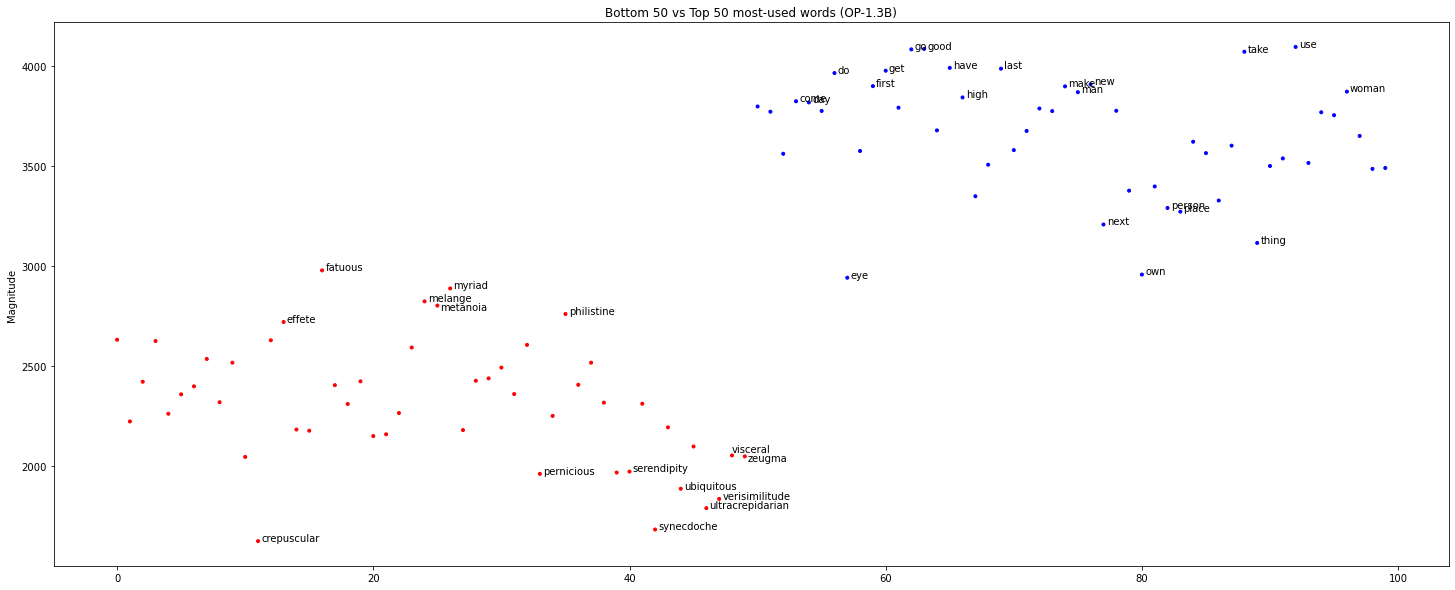

In [117]:
plt.figure(figsize=(25, 10))
plt.title('Bottom 50 vs Top 50 most-used words (OP-1.3B)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_opt, c=colors, marker='.')
for i in range(0, 100):
    if i < 48:
        if i == 25:
            plt.annotate(X[i], (i+0.25, Y_opt[i]-20))
        elif i == 39: continue
        elif Y_opt[i] > 2700:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] < 2000:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
    elif i == 48:
        plt.annotate(X[i], (i, Y_opt[i]+15))
    elif i == 49:
        plt.annotate(X[i], (i+0.25, Y_opt[i]-25))
    else:
        if Y_opt[i] < 3300:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] > 3800:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))


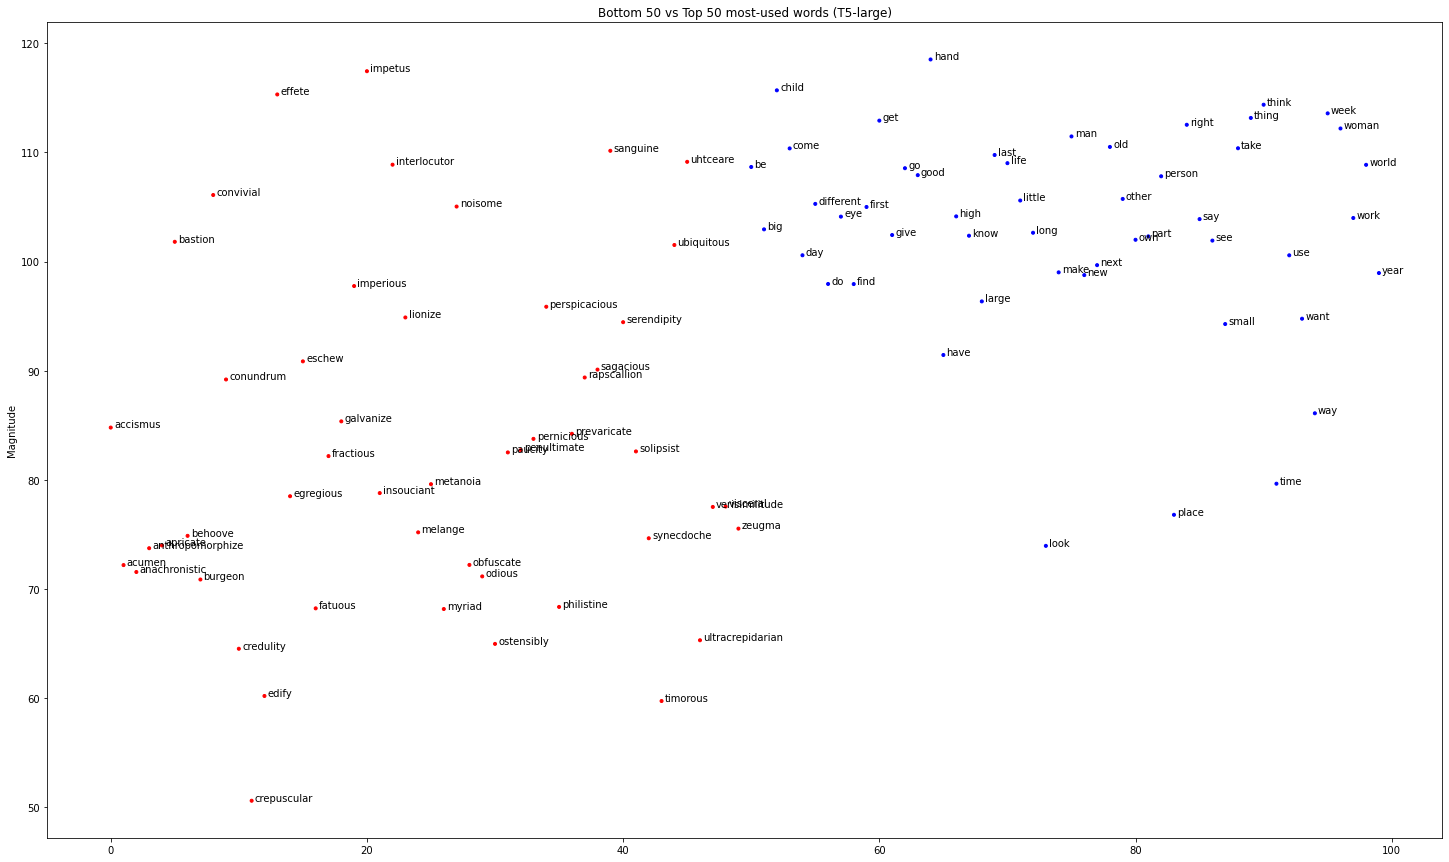

In [116]:
plt.figure(figsize=(25, 15))
plt.title('Bottom 50 vs Top 50 most-used words (T5-large)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_t5, c=colors, marker='.')
for i in range(0, 100):
    plt.annotate(X[i], (i+0.25, Y_t5[i]))

* Revisions

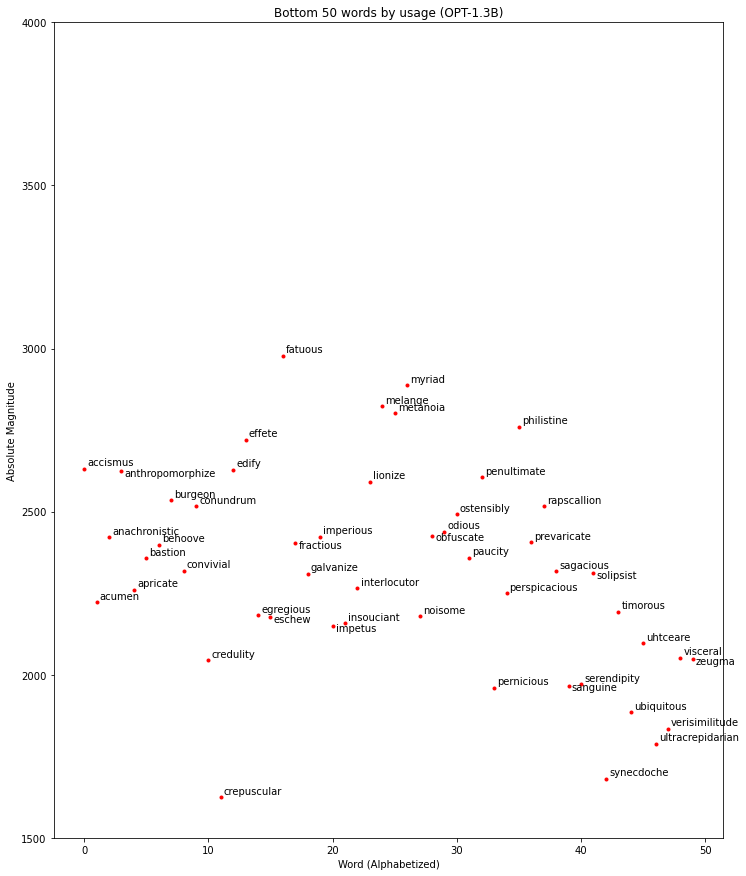

In [89]:
plt.figure(figsize=(12, 15))
plt.title('Bottom 50 words by usage (OPT-1.3B)')
plt.ylabel('Absolute Magnitude')
plt.ylim((1500, 4000))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_opt[:50], c='r', marker='.')

# add labels
for i in range(50):
    if i in [3, 15, 17, 20, 28, 39, 41, 49]:
        plt.annotate(X[i], (i+0.25, Y_opt[i]-15))
    else:    
        plt.annotate(X[i], (i+0.25, Y_opt[i]+10))

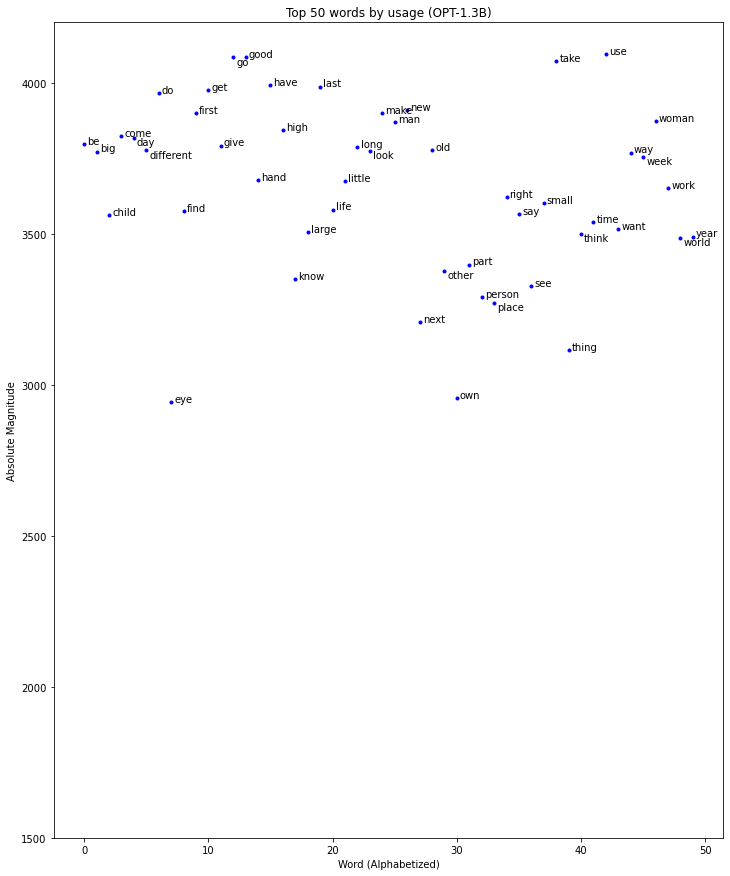

In [128]:
plt.figure(figsize=(12, 15))
plt.title('Top 50 words by usage (OPT-1.3B)')
plt.ylabel('Absolute Magnitude')
plt.ylim((1500, 4200))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_opt[50:], c='b', marker='.')

for i in range(50, 100):
    if i-50 in [4, 5, 12, 23, 29, 33, 40, 45, 48]:
        plt.annotate(X[i], (i-50+0.25, Y_opt[i]-25))
    else: plt.annotate(X[i], (i-50+0.25, Y_opt[i]))

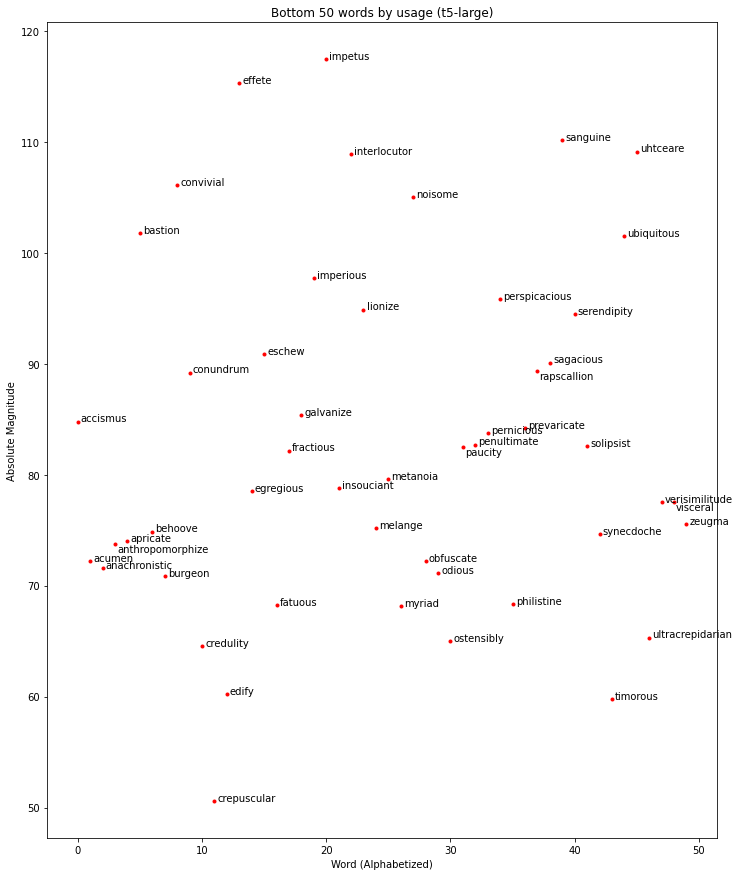

In [116]:
plt.figure(figsize=(12, 15))
plt.title('Bottom 50 words by usage (t5-large)')
plt.ylabel('Absolute Magnitude')
# plt.ylim((45, 125))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_t5[:50], c='r', marker='.')

for i in range(50):
    if i in [3, 31, 37, 48]:
        plt.annotate(X[i], (i+0.15, Y_t5[i]-.75))
    else: plt.annotate(X[i], (i+0.25, Y_t5[i]))

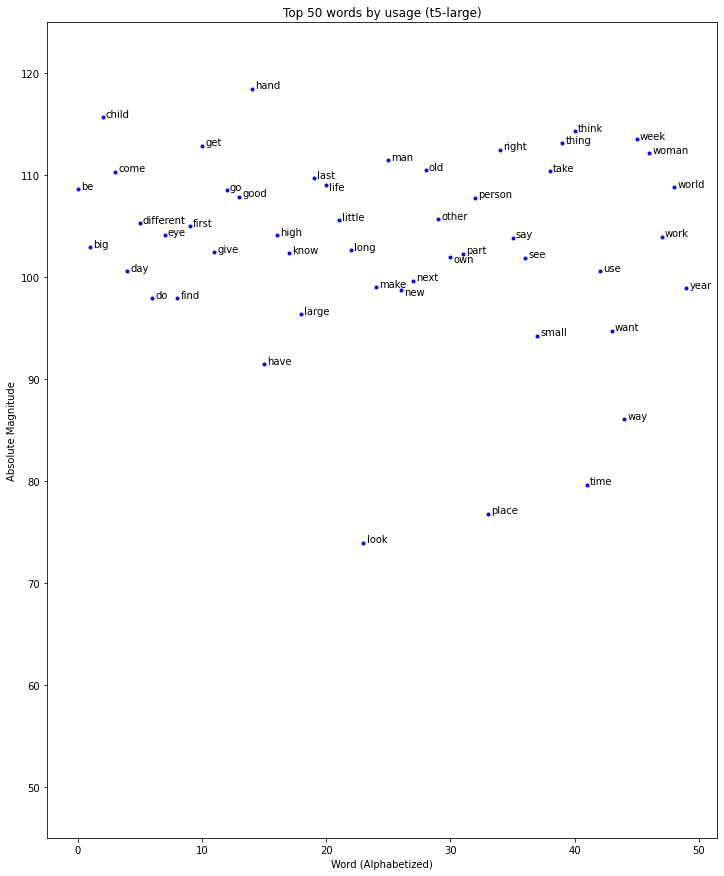

In [120]:
plt.figure(figsize=(12, 15))
plt.title('Top 50 words by usage (t5-large)')
plt.ylabel('Absolute Magnitude')
plt.ylim((45, 125))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_t5[50:], c='b', marker='.')

for i in range(50, 100):
    if (i-50) in [20, 26, 30]:
        plt.annotate(X[i], (i-50 + 0.25, Y_t5[i]-.5))
    else: plt.annotate(X[i], (i-50 + 0.25, Y_t5[i]))